In [1]:
# Fraud Detection Pipeline: End-to-End Code

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)



In [ ]:
file_paths = {
    "account_activity": "account_activity.csv",
    "customer_data": "customer_data.csv",
    "fraud_indicators": "fraud_indicators.csv",
    "suspicious_activity": "suspicious_activity.csv",
    "merchant_data": "merchant_data.csv",
    "transaction_category_labels": "transaction_category_labels.csv",
    "amount_data": "amount_data.csv",
    "anomaly_scores": "anomaly_scores.csv",
    "transaction_metadata": "transaction_metadata.csv",
    "transaction_records": "transaction_records.csv",
}

# Load datasets and store in a dictionary for easy iteration
datasets = {}
for key, path in file_paths.items():
    datasets[key] = pd.read_csv("data/archive/Data/all/" + path)
    print(f"\nDataset: {key} (first 5 rows)")
    print(datasets[key].head())



Dataset: account_activity (first 5 rows)
   CustomerID  AccountBalance   LastLogin
0        1001     9507.272060  2022-01-01
1        1002     7408.704536  2022-01-02
2        1003     1715.321989  2022-01-03
3        1004     3101.509134  2022-01-04
4        1005     5405.766914  2022-01-05

Dataset: customer_data (first 5 rows)
   CustomerID           Name  Age       Address
0        1001  Customer 1001   54  Address 1001
1        1002  Customer 1002   35  Address 1002
2        1003  Customer 1003   40  Address 1003
3        1004  Customer 1004   30  Address 1004
4        1005  Customer 1005   46  Address 1005

Dataset: fraud_indicators (first 5 rows)
   TransactionID  FraudIndicator
0              1               0
1              2               0
2              3               0
3              4               0
4              5               0

Dataset: suspicious_activity (first 5 rows)
   CustomerID  SuspiciousFlag
0        1001               0
1        1002               0
2   

In [ ]:
df_customer = datasets["customer_data"].merge(
    datasets["account_activity"], on="CustomerID", how="inner"
)
df_customer = df_customer.merge(
    datasets["suspicious_activity"], on="CustomerID", how="inner"
)


df_transaction_cat = datasets["fraud_indicators"].merge(
    datasets["transaction_category_labels"], on="TransactionID", how="inner"
)

df_amount = datasets["amount_data"].merge(
    datasets["anomaly_scores"], on="TransactionID", how="inner"
)

df_transaction = datasets["transaction_metadata"].merge(
    datasets["transaction_records"], on="TransactionID", how="inner"
)


df_merged = df_transaction_cat.merge(df_amount, on="TransactionID", how="inner")
df_merged = df_merged.merge(df_transaction, on="TransactionID", how="inner")

if "CustomerID" in df_customer.columns and "CustomerID" in df_merged.columns:
    df_final = df_customer.merge(df_merged, on="CustomerID", how="inner")
else:
    df_final = df_customer.merge(df_merged, on="TransactionID", how="inner")

print("\nConsolidated dataset (first 5 rows):")
print(df_final.head())
print("\nDataset structure:")
print(df_final.info())
print(f"\nUnique CustomerIDs: {df_final['CustomerID'].nunique()}")
print(f"Unique TransactionIDs: {df_final['TransactionID'].nunique()}")



Consolidated dataset (first 5 rows):
   CustomerID           Name  Age       Address  AccountBalance   LastLogin  \
0        1001  Customer 1001   54  Address 1001     9507.272060  2022-01-01   
1        1003  Customer 1003   40  Address 1003     1715.321989  2022-01-03   
2        1004  Customer 1004   30  Address 1004     3101.509134  2022-01-04   
3        1004  Customer 1004   30  Address 1004     3101.509134  2022-01-04   
4        1005  Customer 1005   46  Address 1005     5405.766914  2022-01-05   

   SuspiciousFlag  TransactionID  FraudIndicator Category  TransactionAmount  \
0               0            787               0     Food          87.375444   
1               0            641               0   Travel          46.044172   
2               0            450               0    Other          85.085061   
3               0            921               0    Other          36.534720   
4               0            599               0    Other          82.852025   

   Ano

In [ ]:
# Separate numerical and categorical features.
numerical_features = df_final.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_final.select_dtypes(include=[object]).columns.tolist()

print("\nNumerical Features Identified:")
print(numerical_features)
print("\nCategorical Features Identified:")
print(categorical_features)
print("\nSummary Statistics of Numerical Features:")
print(df_final[numerical_features].describe())
print("\nSample values of Categorical Features:")
print(df_final[categorical_features].head())



Numerical Features Identified:
['CustomerID', 'Age', 'AccountBalance', 'SuspiciousFlag', 'TransactionID', 'FraudIndicator', 'TransactionAmount', 'AnomalyScore', 'MerchantID', 'Amount']

Categorical Features Identified:
['Name', 'Address', 'LastLogin', 'Category', 'Timestamp']

Summary Statistics of Numerical Features:
        CustomerID          Age  AccountBalance  SuspiciousFlag  \
count  1000.000000  1000.000000     1000.000000     1000.000000   
mean   1496.626000    39.848000     5715.455931        0.025000   
std     289.229047    13.074932     2540.517262        0.156203   
min    1001.000000    18.000000     1056.301181        0.000000   
25%    1239.000000    29.000000     3489.554711        0.000000   
50%    1501.000000    39.000000     5753.007775        0.000000   
75%    1739.250000    51.000000     7925.710167        0.000000   
max    2000.000000    64.000000     9999.776239        1.000000   

       TransactionID  FraudIndicator  TransactionAmount  AnomalyScore  \
co

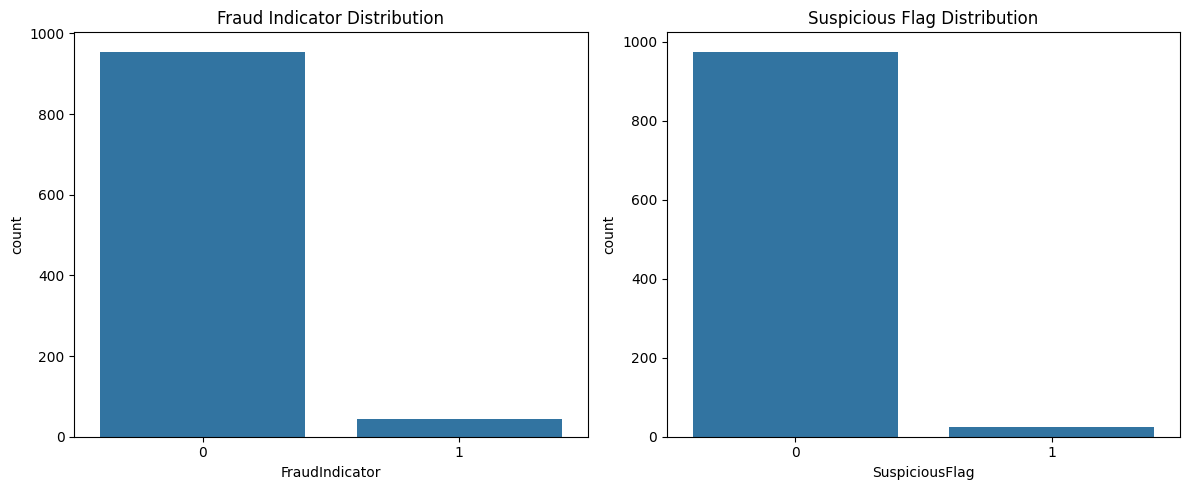

In [ ]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x="FraudIndicator", data=df_final)
plt.title("Fraud Indicator Distribution")

plt.subplot(1, 2, 2)
sns.countplot(x="SuspiciousFlag", data=df_final)
plt.title("Suspicious Flag Distribution")
plt.tight_layout()
plt.show()


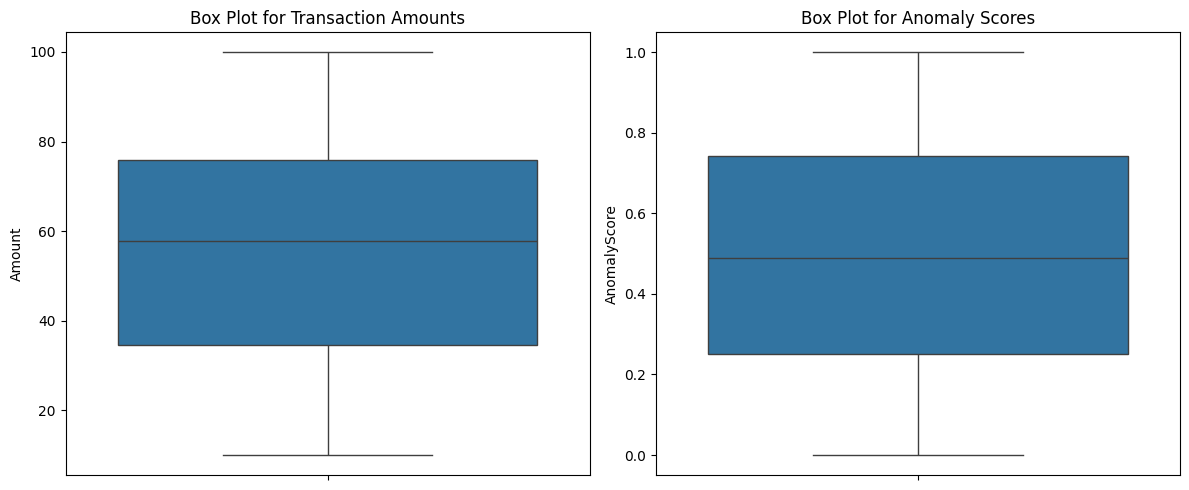

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y="Amount", data=df_final)
plt.title("Box Plot for Transaction Amounts")

plt.subplot(1, 2, 2)
sns.boxplot(y="AnomalyScore", data=df_final)
plt.title("Box Plot for Anomaly Scores")
plt.tight_layout()
plt.show()


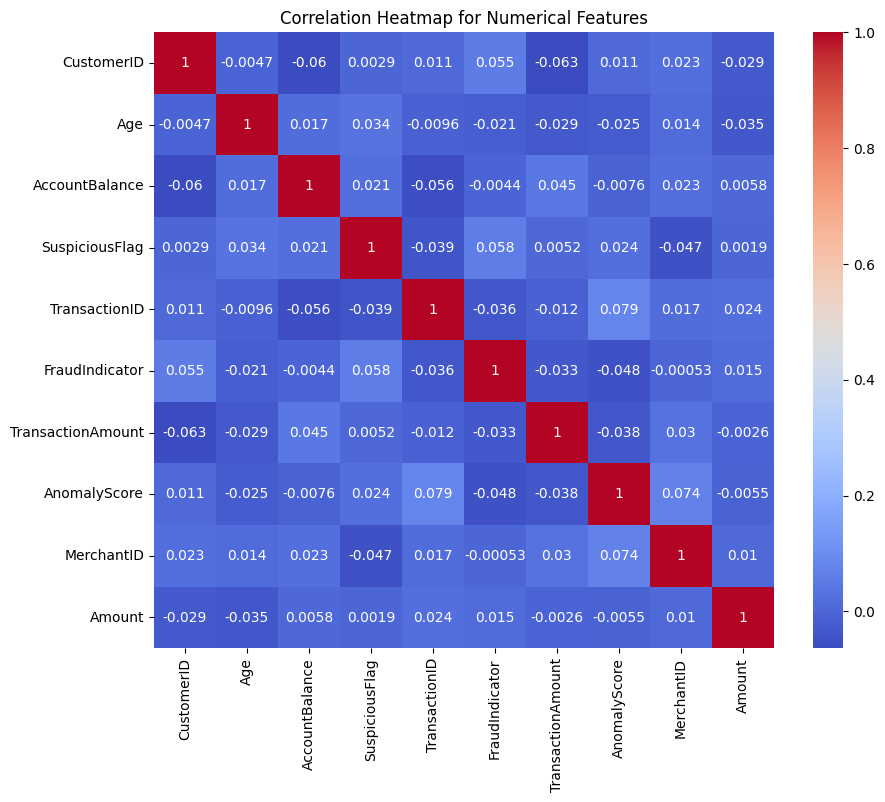

In [12]:

# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df_final[numerical_features].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap for Numerical Features")
plt.show()


In [ ]:

# Remove columns not contributing to fraud detection.
cols_to_remove = ["TransactionID", "MerchantID", "CustomerID", "Name", "Age", "Address"]
df_cleaned = df_final.drop(
    columns=[col for col in cols_to_remove if col in df_final.columns]
)

print("\nCleaned dataset shape:", df_cleaned.shape)
print("\nColumns removed: ", cols_to_remove)
print("\nDistribution Analysis of key features:")
print("FraudIndicator distribution:")
print(df_final["FraudIndicator"].value_counts())
print("\nSuspiciousFlag distribution:")
print(df_final["SuspiciousFlag"].value_counts())
print("\nCategory sample values:")
print(df_final["Category"].value_counts().head())



Cleaned dataset shape: (1000, 9)

Columns removed:  ['TransactionID', 'MerchantID', 'CustomerID', 'Name', 'Age', 'Address']

Distribution Analysis of key features:
FraudIndicator distribution:
FraudIndicator
0    955
1     45
Name: count, dtype: int64

SuspiciousFlag distribution:
SuspiciousFlag
0    975
1     25
Name: count, dtype: int64

Category sample values:
Category
Other     210
Food      204
Travel    198
Online    196
Retail    192
Name: count, dtype: int64


In [18]:
df_cleaned.head()

,AccountBalance,LastLogin,SuspiciousFlag,FraudIndicator,Category,TransactionAmount,AnomalyScore,Timestamp,Amount,Hour,Gap
0,9507.272060,2022-01-01,0,0,Food,87.375444,0.030921,2022-02-02 18:00:00,33.670626,18,786.0
1,1715.321989,2022-01-03,0,0,Travel,46.044172,0.961552,2022-01-27 16:00:00,30.980239,16,592.0
2,3101.509134,2022-01-04,0,0,Other,85.085061,0.525809,2022-01-19 17:00:00,11.167088,17,377.0
3,3101.509134,2022-01-04,0,0,Other,36.534720,0.652188,2022-02-08 08:00:00,45.849784,8,848.0
4,5405.766914,2022-01-05,0,0,Other,82.852025,0.661493,2022-01-25 22:00:00,81.808651,22,502.0


In [19]:
df_cleaned.dtypes

AccountBalance              float64
LastLogin            datetime64[ns]
SuspiciousFlag                int64
FraudIndicator                int64
Category                     object
TransactionAmount           float64
AnomalyScore                float64
Timestamp            datetime64[ns]
Amount                      float64
Hour                          int32
Gap                         float64
dtype: object

In [14]:
df_cleaned["Timestamp"] = pd.to_datetime(df_cleaned["Timestamp"])
df_cleaned["Hour"] = df_cleaned["Timestamp"].dt.hour


df_cleaned["LastLogin"] = pd.to_datetime(df_cleaned["LastLogin"])
df_cleaned["Gap"] = (
    df_cleaned["Timestamp"] - df_cleaned["LastLogin"]
).dt.total_seconds() / 3600.0  

print("\nNew features created (Hour, Gap):")
print(df_cleaned[["Hour", "Gap"]].head())
print("\nCategorical features transformation summary:")
# (We will later encode categorical variables; see next step.)



New features created (Hour, Gap):
   Hour    Gap
0    18  786.0
1    16  592.0
2    17  377.0
3     8  848.0
4    22  502.0

Categorical features transformation summary:


In [23]:
df_cleaned2 = df_cleaned.copy()

In [24]:
df_cleaned.dtypes

AccountBalance              float64
LastLogin            datetime64[ns]
SuspiciousFlag                int64
FraudIndicator                int64
Category                     object
TransactionAmount           float64
AnomalyScore                float64
Timestamp            datetime64[ns]
Amount                      float64
Hour                          int32
Gap                         float64
dtype: object

In [25]:
df_cleaned = df_cleaned.drop(columns=["LastLogin", "Timestamp"])

In [26]:
# Ensure FraudIndicator is in the dataset.
if "FraudIndicator" not in df_cleaned.columns:
    raise ValueError("Target column 'FraudIndicator' not found in dataset.")

# Define X (all columns except target) and Y (target)
X = df_cleaned.drop("FraudIndicator", axis=1)
Y = df_cleaned["FraudIndicator"]

# Encode categorical variables using LabelEncoder
# Loop through object dtype columns in X
for col in X.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    print(f"Encoded {col}")

print("\nFeature dimensions before train-test split:")
print("X shape:", X.shape, "Y shape:", Y.shape)

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)
print("\nTraining set dimensions:", X_train.shape, Y_train.shape)
print("Test set dimensions:", X_test.shape, Y_test.shape)


Encoded Category

Feature dimensions before train-test split:
X shape: (1000, 8) Y shape: (1000,)

Training set dimensions: (800, 8) (800,)
Test set dimensions: (200, 8) (200,)


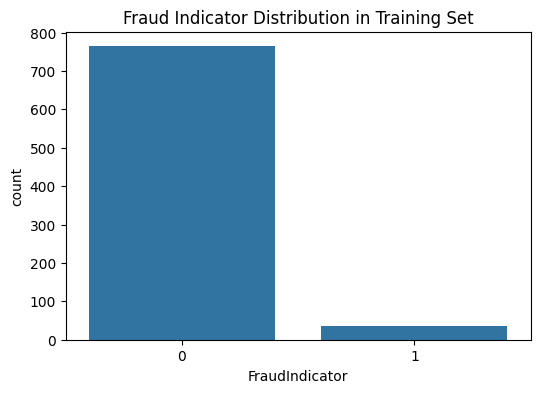

In [27]:

# Check data balance (visualize target distribution)
plt.figure(figsize=(6, 4))
sns.countplot(x=Y_train)
plt.title("Fraud Indicator Distribution in Training Set")
plt.show()


In [28]:

print("\nBefore SMOTE - Class distribution:")
print(Y_train.value_counts())

# Apply SMOTE if the data is imbalanced (if FraudIndicator is skewed)
sm = SMOTE(random_state=42)
X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)

print("\nAfter SMOTE - Class distribution:")
print(pd.Series(Y_train_res).value_counts())



Before SMOTE - Class distribution:
FraudIndicator
0    764
1     36
Name: count, dtype: int64

After SMOTE - Class distribution:
FraudIndicator
0    764
1    764
Name: count, dtype: int64


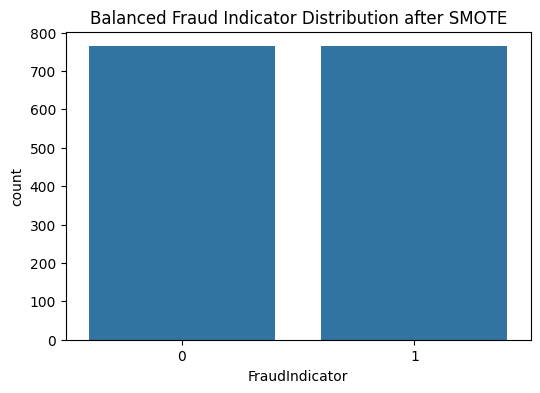

In [29]:

# Visualize class distribution after SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=Y_train_res)
plt.title("Balanced Fraud Indicator Distribution after SMOTE")
plt.show()


In [30]:

# Train a Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_res, Y_train_res)
Y_pred_dt = dt_model.predict(X_test)

# Train a Random Forest Classifier with basic parameters
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_res, Y_train_res)
Y_pred_rf = rf_model.predict(X_test)




Decision Tree Performance:
Accuracy: 0.8100
Precision: 0.0323
Recall: 0.1111
F1-score: 0.0500


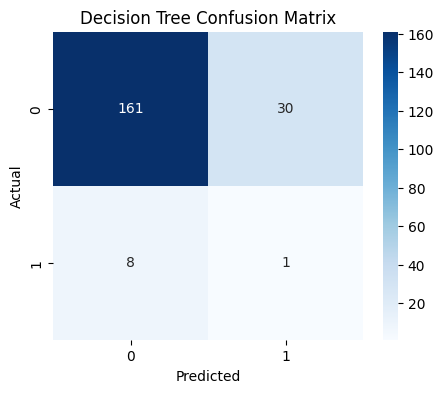


Random Forest Performance:
Accuracy: 0.8650
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


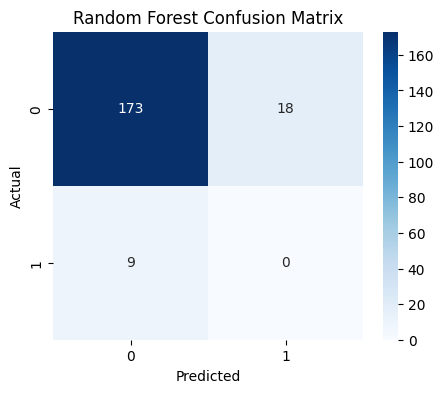

In [31]:

# Evaluate models
def evaluate_model(y_true, y_pred, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n{model_name} Performance:")
    print(
        f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF1-score: {f1:.4f}"
    )
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()


evaluate_model(Y_test, Y_pred_dt, model_name="Decision Tree")
evaluate_model(Y_test, Y_pred_rf, model_name="Random Forest")


In [32]:

# Hyperparameter tuning using GridSearchCV for Random Forest
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
}
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42), param_grid, cv=3, scoring="f1", n_jobs=-1
)
grid_rf.fit(X_train_res, Y_train_res)
print("\nBest parameters for Random Forest:")
print(grid_rf.best_params_)



Best parameters for Random Forest:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}



Tuned Random Forest Performance:
Accuracy: 0.8650
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


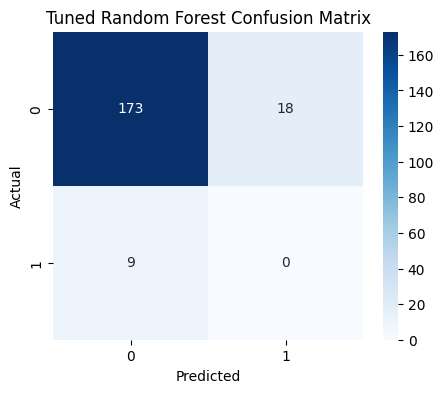

In [33]:

best_rf = grid_rf.best_estimator_
Y_pred_best_rf = best_rf.predict(X_test)
evaluate_model(Y_test, Y_pred_best_rf, model_name="Tuned Random Forest")


In [34]:

unseen_predictions = best_rf.predict(X_test)
print("\nPredictions on unseen data (first 10):")
print(unseen_predictions[:10])


Predictions on unseen data (first 10):
[0 0 0 0 0 0 0 1 0 0]
